## 0.0 Imports

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import inflection

from IPython.core.display import HTML
from IPython.core.display import Image

### 0.1 Helper Functions

In [3]:
def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()

### 0.2 Loading Data

In [4]:
df_store_raw = pd.read_csv('data/train.csv', low_memory=False)
df_features_raw = pd.read_csv('data/stores.csv', low_memory=False)

#merge
df_raw = pd.merge(df_store_raw, df_features_raw, on='Store', how='left')

In [5]:
df_raw.sample()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
353861,38,2,2010-02-26,10126.21,False,C,39690


## 1.0 Descrição Dos Dados

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size'], dtype='object')

### 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [9]:
df1.sample()

,store,dept,date,weekly_sales,is_holiday,type,size
13542,2,25,2010-11-05,17019.23,False,A,202307


### 1.2 Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 421570
Number of Cols: 7


### 1.3 Data Types

In [11]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
type             object
size              int64
dtype: object

### 1.4 Check NA

In [12]:
df1.isna().sum()

store           0
dept            0
date            0
weekly_sales    0
is_holiday      0
type            0
size            0
dtype: int64

### Fillout Na

### 1.6 Change Types

In [13]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
type             object
size              int64
dtype: object

In [14]:
df1['date'] = pd.to_datetime(df1['date'])

In [15]:
df1.dtypes

store                    int64
dept                     int64
date            datetime64[ns]
weekly_sales           float64
is_holiday                bool
type                    object
size                     int64
dtype: object

### 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,45.00,44.0,22.200546,22.00,12.785282,0.077763,-1.146503
1,dept,1.00,99.00,98.0,44.260317,37.00,30.492018,0.358223,-1.215571
2,weekly_sales,-4988.94,693099.36,698088.3,15981.258123,7612.03,22711.156583,3.262008,21.491290
3,size,34875.00,219622.00,184747.0,136727.915739,140167.00,60980.511002,-0.325850,-1.206346


C:\Users\AMD\anaconda3\envs\walmart_sales_store\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weekly_sales'>

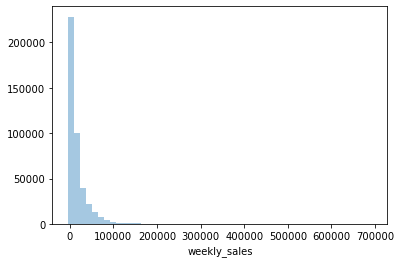

In [18]:
sns.distplot( df1['weekly_sales'], kde=False )

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

is_holiday    2
type          3
dtype: int64

<AxesSubplot:xlabel='type', ylabel='weekly_sales'>

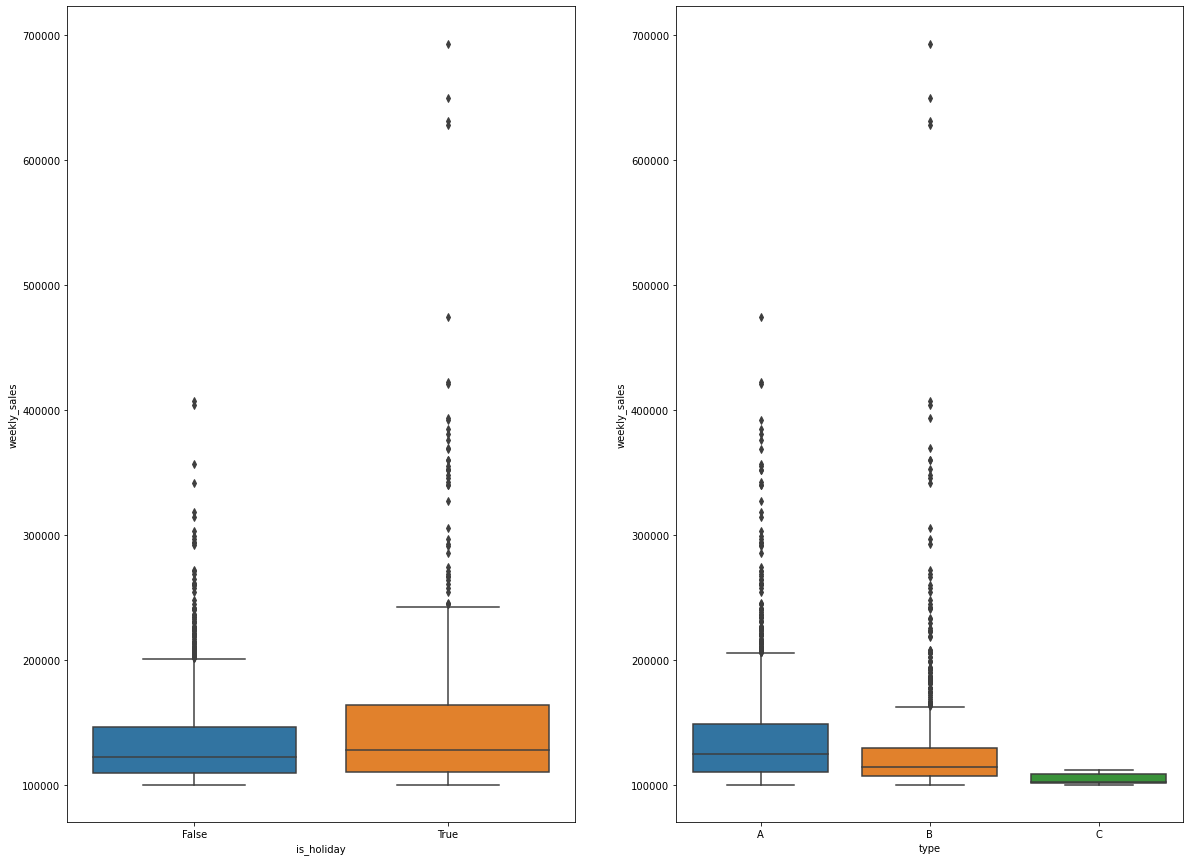

In [20]:
plt.figure(figsize=(20,15))
aux1 = df1[(df1['is_holiday'] != '0') & (df1['weekly_sales'] > 100000)]

plt.subplot( 1, 2, 1 )
sns.boxplot( x='is_holiday', y='weekly_sales', data=aux1 ) 

plt.subplot( 1, 2, 2 )
sns.boxplot( x='type', y='weekly_sales', data=aux1 )

## 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

###  2.1 Mapa mental de Hipoteses

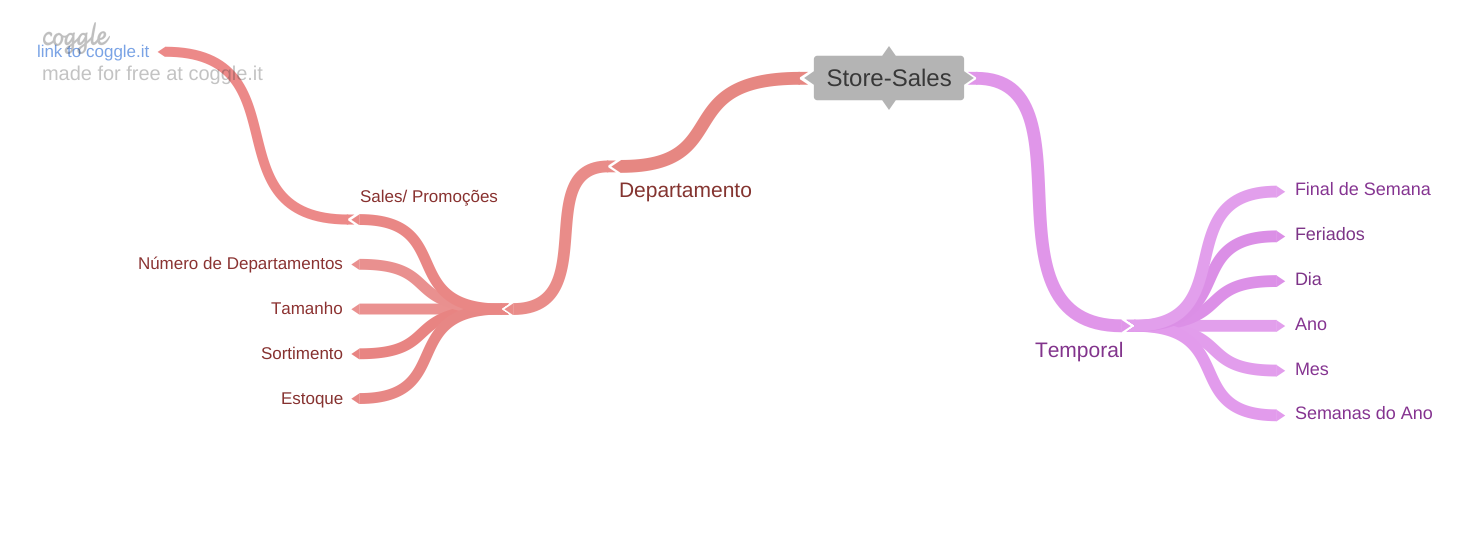

In [22]:
Image('img/MindMapHypothesis.png')

###  2.1 Criação das Hipoteses

#### **2.1** Hipotese Loja

**1.** Lojas de maior tamanho deveriam vender mais.

**2.** Lojas com maior sortimento de produtos deveriam vender mais

**3.** Lojas com promoções deveriam vender mais

#### 2.1 Hipotese Tempo 

**1.** Lojas deveriam vender mais aos finais de semana

**2.** Lojas deveriam vender menos aos feriados

**3.** Lojas vendem mais no primeiro semestre do ano

### 2.2 Lista final de Hipoteses

**1.** Lojas de maior tamanho deveriam vender mais.

**2.** Lojas com maior sortimento de produtos deveriam vender mais

**3.** Lojas com promoções deveriam vender mais



**4.** Lojas deveriam vender mais aos finais de semana

**5.** Lojas deveriam vender menos aos feriados

**6.** Lojas vendem mais no primeiro semestre do ano

### 2.3 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# assortment
df2['type'] = df2['type'].apply(lambda x: 'basic' if x == 'a' else 
                                          'extra' if x == 'b' else 'extended')

C:\Users\AMD\AppData\Local\Temp/ipykernel_5184/2725536907.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


## 3.0 Filtragem de Variaveis

In [49]:
df3 = df2.copy()

### 3.1 Filtragem das Linha

In [50]:
df3 = df3['weekly_sales'] > 0

### 3.2 Seleção das Colunas

In [51]:
cols_drop = ['dept']
df3 = df3.drop(cols_drop, axis=1)

ValueError: No axis named 1 for object type Series

In [52]:
df3.columns

AttributeError: 'Series' object has no attribute 'columns'